In [1]:
from occurrencerateclass import *
#from astropy.visualization import astropy_mpl_style
#plt.style.use(astropy_mpl_style)
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from astropy.coordinates import get_sun, get_moon
from estimate_PDF import get_samples_from_percentiles
import matplotlib.ticker
%matplotlib inline


Bad key "xtick.labeltop" on line 358 in
/Users/ryancloutier/.matplotlib/matplotlibrc.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
# get planet data
self = loadpickle('PipelineResults_TIC/TIC_results_0_10000_det_8d4')
g = self.disposition_human >= 0
assert g.sum() == 16

/Users/ryancloutier/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in greater_equal
  app.launch_new_instance()


In [3]:
# get ephemerides
g1 = np.in1d(self.disposition_human, [2,2.5])
g2 = np.in1d(self.disposition_human, [0,1])
Ps = np.append(self.Ps_singletransit[g1], self.Ps[g2])
ehiPs = np.append(self.ehi_Ps_singletransit[g1], self.e_Ps[g2])
eloPs = np.append(self.elo_Ps_singletransit[g1], self.e_Ps[g2])
T0s = np.append(self.T0s[g1], self.T0s[g2])
eT0s = np.append(self.e_T0s[g1], self.e_T0s[g2])
ras = np.append(self.ras[g1], self.ras[g2])
decs = np.append(self.decs[g1], self.decs[g2])
tics = np.append(self.tics[g1], self.tics[g2])

In [60]:
# define plotting function for one source
def plot_visibility(TIC, ra_deg, dec_deg, UTCoffset, Ps=np.zeros(3), T0s=np.zeros(2), duration_days=6, saveplt=False):
    
    c = SkyCoord(ra_deg, dec_deg, frame='icrs', unit='deg')

    # define time array
    midnight = Time('2019-2-19 00:00:00') - UTCoffset
    delta_days = np.linspace(-duration_days/2., duration_days/2., 5000)*u.day
    times = midnight + delta_days
    frame = AltAz(obstime=times, location=loc)

    # get altitude vs time
    altazs = c.transform_to(frame)
    airmass = altazs.secz
    
    # get Sun's location
    sunaltazs = get_sun(times).transform_to(frame)

    # get Moon's location
    moonaltazs = get_moon(times).transform_to(frame)
    
    # plot airmass
    pltsecz = 0
    if pltsecz:
        plt.plot(delta_days, airmass)
        plt.ylim(1, 4)
        plt.xlabel('Delta Days')
        plt.ylabel('Airmass [Sec(z)]')
        
    # plot all sources
    pltfull = 1
    if pltfull:
        fig = plt.figure(figsize=(14,6))
        ax = fig.add_subplot(111)
        ax.plot(delta_days, sunaltazs.alt, color='r', label='Sun')
        ax.plot(delta_days, moonaltazs.alt, color=[0.75]*3, ls='--', label='Moon')
        img = ax.scatter(delta_days, altazs.alt, c=altazs.az, label='Target', lw=0, s=25,
                         cmap=plt.get_cmap('rainbow'))
        ax.fill_between(delta_days.to('day').value, 0, 90,
                        sunaltazs.alt < -0*u.deg, color='0.5', zorder=0)
        ax.fill_between(delta_days.to('day').value, 0, 90,
                        sunaltazs.alt < -18*u.deg, color='k', zorder=0)
        cbarax = fig.add_axes([.96, .1, .025, .8])
        cbar = fig.colorbar(img, cax=cbarax)
        cbar.set_label('Azimuth [deg]', fontsize=12)
        fig.legend(loc='upper left')
        mn, mx = ax.set_ylim(0, 90)
        ax.set_xlim((delta_days.to('day').value.min(),delta_days.to('day').value.max()))
        ax.set_xlabel('Days since local midnight on Feb 19, 2019', fontsize=12)
        ax.set_ylabel('Altitude [deg]', fontsize=12)
        ax.set_title('TIC = %i\nRA = %.3f deg, Dec = %.3f deg'%(TIC,ra_deg,dec_deg), y=1.02)

        # plot planet transits
        if Ps[0] > 0:
            P, ehiP, eloP = Ps
            samp_P = get_samples_from_percentiles(P, ehiP, eloP)
            T0, eT0 = T0s
            T0 += abs(times.jd.mean() - T0)
            samp_T0 = get_samples_from_percentiles(T0, eT0, eT0)
            Ntransits = np.ceil(float(duration_days)/P)
            for k in np.arange(-Ntransits, Ntransits+1):
                intransit = np.linspace(T0+(P-eloP)*k, T0+(P+ehiP)*k, 2)
                print intransit, times.jd.min(), times.jd.max()
                ax.fill_between(intransit, np.zeros(2), np.zeros(2)+90, color='b', alpha=.3)

        # add airmass axis
        ax2 = ax.twinx()
        ##airmass = lambda alt: 1 / np.cos(np.pi/2 - np.deg2rad(alt))
        altitude = lambda X: 90 - np.rad2deg(np.arccos(1./X))
        ax2.set_ylim(0,90)
        airmasses = np.array([1,1.1,1.2,1.4,2,5])
        yticks = np.sort(altitude(airmasses))
        ax2.set_yticks(yticks)
        ax2.set_yticklabels(airmasses[::-1])
        ax2.set_ylabel('Airmass', fontsize=12)
        for h in altitude(airmasses): ax2.axhline(h, color='grey', lw=.8)
        
        # add months for yearly plots
        #ax2 = ax.twinx()
        #xticks = np.cumsum([0,31,28,31,30,31,30,31,31,30,31,30,31])
        #xticklabels = ['J','F','M','A','M','J','J','A','S','O','N','D']
        #ax2.set_xticks(xticks)
        #ax2.set_xticklabels(xticklabels)
        plt.savefig('DragonflyPlots/Dragonfly_visibility_TIC%i.png'%TIC)
        plt.show()

In [61]:
# define observing location
lat = 32 + 54./60       # New mexico skies
lon = -105 + 32./60
elevation = 2788        # meters
UTCoffset = -6*u.hour   # New mexico
loc = EarthLocation(lat=lat*u.deg, lon=lon*u.deg, height=elevation*u.m)

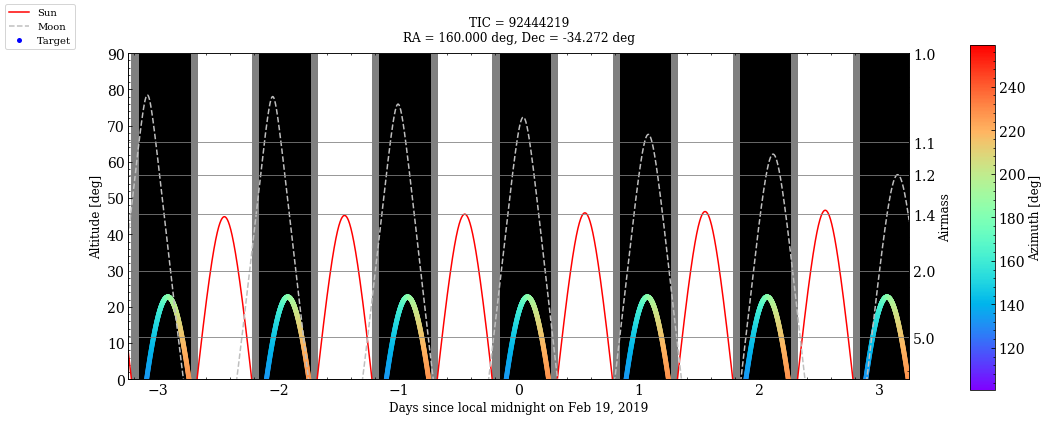

In [64]:
for i in range(1):
    plot_visibility(tics[i], 160, decs[i], UTCoffset, duration_days=6.5, saveplt=False)